# YOUTUBE SENTIMENT ANALYSIS
#Written by Veo Chae
#Referencing from Abudllah Zahid

In [1]:
#This script takes the 2 datasets acquired through the Youtube Web Scraping Script
#This script takes the 1 dataset acquired through Media Bias Methodology by Ad Fontes Media

############# THIS IS THE START OF THE SCRIPT ###################

In [1]:
#1. Packages Utilized
import numpy as np # linear algebraimport pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS

plt.rc('figure',figsize=(17,13))
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
import vaderSentiment
import twython

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dchae2\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
#2. Data Import
data = pd.read_csv('C:/Users/dchae2/Desktop/Youtube Analysis/Sentiment Analysis/Left_Youtube_finalized.csv')
    #this is the left-sided media bias youtube videos (script, title, likes, dislikes, publisher)
data = data.drop([42])
    #the last observation did not contain a script due to Youtube Malfunction, thus dropped
data_1 = pd.read_csv('C:/Users/dchae2/Desktop/Youtube Analysis/Sentiment Analysis/Right_Youtube_finalized.csv')
    #this is the right-sided bias youtube videos (script, title, likes, dislikes, publisher)
bias = pd.read_csv('C:/Users/dchae2/Desktop/Youtube Analysis/Sentiment Analysis/Media Bias.csv')
    #this is the media bias reference dataset acquired through Ad Fontes Media
data = data.append(data_1)
data = data.merge(bias, on = "uploader", how = "left")


#data cleaning
data['scripts'] = data['scripts'].str.replace('WEBVTT', '')
data['scripts'] = data['scripts'].str.replace(' Kind: captions', '')
data['scripts'] = data['scripts'].str.replace(' Language: en', '')

data.info()
    #all scripts contained heading, thus deletion of heading took place

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   uploader       52 non-null     object
 1   like_count     52 non-null     int64 
 2   dislike_count  52 non-null     int64 
 3   title          52 non-null     object
 4   scripts        52 non-null     object
 5   Bias           36 non-null     object
 6   Country        49 non-null     object
dtypes: int64(2), object(5)
memory usage: 3.2+ KB


In [4]:
#3. Data Cleansing for NLP Usage --- Referenced from Abdullah Zahid's Sentiment Analysis Script
def clean(text):
     text = re.sub('https?://\S+|www\.\S+', '', text)
     text = re.sub(r'\s+', ' ', text, flags=re.I)
     text = re.sub('\[.*?\]', '', text)
     text = re.sub('\n', '', text)
     text = re.sub('\w*\d\w*', '', text)
     text = re.sub('<.*?>+', '', text)
     return text

data['scripts'] = data['scripts'].apply(lambda x:clean(x))


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
scores=[]
for i in range(len(data['scripts'])):
     score = analyser.polarity_scores(data['scripts'][i])
     score=score['compound']
     scores.append(score)  
     
sentiment=[]
for i in scores:
     if i>=0.05:
         sentiment.append('Positive')
     elif i<=(-0.05):
         sentiment.append('Negative')
     else:
         sentiment.append('Neutral')

data['sentiment']=pd.Series(np.array(sentiment))


def clean_text(text):
    
    text = str(text).lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    return text

data['scripts'] = data['scripts'].apply(lambda x:clean_text(x))
data['scripts']


##Performing Stemming and Lemmatization

data_2=pd.DataFrame()
data_2['text']=data['scripts']


def tokenization(text):
     text = re.split('\W+', text)
     return text

data_2['tokenized'] = data_2['text'].apply(lambda x: tokenization(x.lower()))
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
     text = [word for word in text if word not in stopword]
     return text

data_2['No_stopwords'] = data_2['tokenized'].apply(lambda x: remove_stopwords(x))

ps = nltk.PorterStemmer()

def stemming1(text):
     text = [ps.stem(word) for word in text]
     return text 

data_2['stemmed_porter'] = data_2['No_stopwords'].apply(lambda x: stemming1(x))


from nltk.stem.snowball import SnowballStemmer
s_stemmer = SnowballStemmer(language='english')
def stemming2(text):
     text = [s_stemmer.stem(word) for word in text]
     return text
data_2['stemmed_snowball'] = data_2['No_stopwords'].apply(lambda x: stemming2(x))
wn = nltk.WordNetLemmatizer()
def lemmatizer(text):
     text = [wn.lemmatize(word) for word in text]
     return text

nltk.download('wordnet')

data_2['lemmatized'] = data_2['No_stopwords'].apply(lambda x: lemmatizer(x))
data_2.head()

data['text'] = data_2['lemmatized']
data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dchae2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dchae2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,uploader,like_count,dislike_count,title,scripts,Bias,Country,sentiment,text
0,TODAY,1490,4153,Vaccine Hesitancy Amid Growing COVID-19 Cases ...,in many parts of the country new cases are go...,Left,USA,Positive,"[, many, part, country, new, case, going, wron..."
1,CBC News: The National,484,2502,Vaccine hesitancy a looming hurdle to ending p...,we know that without a vaccine we dont get th...,NaN,Canada,Positive,"[, know, without, vaccine, dont, get, pandemic..."
2,KVUE,4,7,Vaccine hesitancy still impacting Austin's Lat...,one group of texans who have been disproporti...,NaN,Texas,Negative,"[, one, group, texan, disproportionately, impa..."
3,Osmosis,232,70,Vaccine hesitancy,when arise harahap ikimashita music awards an...,NaN,NaN,Positive,"[, arise, harahap, ikimashita, music, award, f..."
4,BBC News,432,679,Coronavirus: What’s behind vaccine-hesitancy? ...,the world health organization says vaccine he...,Center,UK,Negative,"[, world, health, organization, say, vaccine, ..."


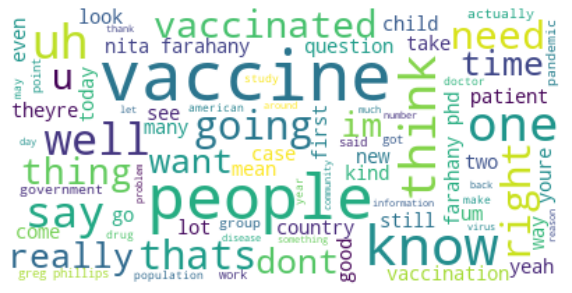

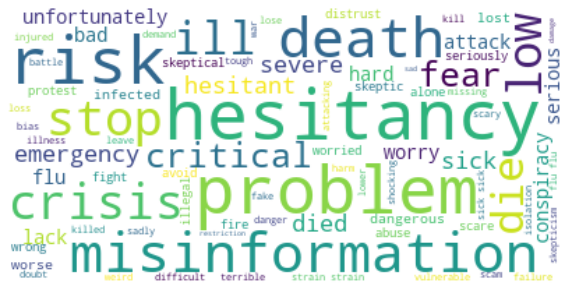

In [5]:
#4. Examining the overall Most Common Words --- Word Cloud Chart included

work = data[['sentiment','text']]
    #work: subset dataset that includes only the sentiment and lemmatized texts
    
a = []
b = []
for i in range(len(work['text'])):
    a = " ".join(work['text'][i])
    b.append(a)
    #appending all tokenized words into a list

b = pd.DataFrame(b)
b.columns = {'script'}
c = ' '.join(b['script'])



#WORDCLOUD: 80 Most Commonly Occurred Words within the Entire Dataset regardless of the sentiment
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
fig, ax = plt.subplots(1, 1, figsize  = (10,10))
wordcloud_ALL = WordCloud(max_font_size=50, max_words=80, background_color="white").generate(c)
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.axis('off')
plt.show(wordcloud_ALL)

c = tokenization(c)
c = pd.DataFrame(c)
c.columns = {'words'}
    #tokenized and made list c into dataframe such that each word's sentiment and polarity score can be recorded

scores=[]
for i in range(len(c['words'])):
     score = analyser.polarity_scores(c['words'][i])
     score=score['compound']
     scores.append(score)  
     
sentiment=[]
for i in scores:
     if i>=0.05:
         sentiment.append('Positive')
     elif i<=(-0.05):
         sentiment.append('Negative')
     else:
         sentiment.append('Neutral')
         
c['sentiment']=pd.Series(np.array(sentiment))

d = c[c['sentiment']=='Negative'].reset_index() #exchange to positive or neutral
e = ' '.join(d['words'])

#WORDCLOUD: 80 Most Commonly Occurred Negative Words within the Entire Dataset
fig, ax = plt.subplots(1, 1, figsize  = (10,10))
wordcloud_ALL = WordCloud(max_font_size=50, max_words=80, background_color="white").generate(e)
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.axis('off')
plt.show(wordcloud_ALL)

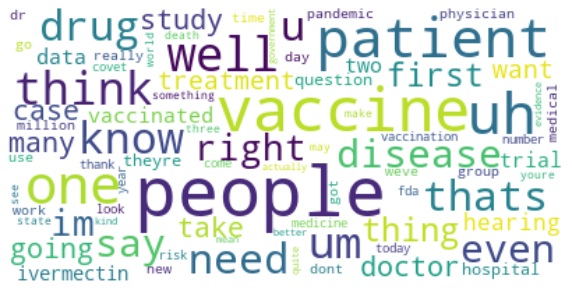

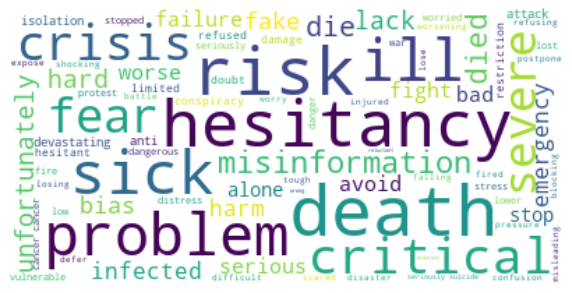

In [9]:
#5. Left Media Bias News Channel Subset Sentiment Analysis

left = data[data['Bias']=='Left'].reset_index()
left = left[['sentiment','text']]
    #left: subset of only the videos that have publishers in the "left" media bias

a_left = []
b_left = []
for i in range(len(left['text'])):
    a_left = " ".join(left['text'][i])
    b_left.append(a_left)

b_left = pd.DataFrame(b_left)
b_left.columns = {'script'}

c_left = ' '.join(b_left['script'])

#WORDCLOUD: 80 Most Commonly Occurred Words within the Left Bias Dataset regardless of the sentiment
fig, ax = plt.subplots(1, 1, figsize  = (10,10))
wordcloud_ALL = WordCloud(max_font_size=50, max_words=80, background_color="white").generate(c_left)
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.axis('off')
plt.show(wordcloud_ALL)

c_left = tokenization(c_left)
c_left = pd.DataFrame(c_left)
c_left.columns = {'words'}

scores=[]
for i in range(len(c_left['words'])):
     score = analyser.polarity_scores(c_left['words'][i])
     score=score['compound']
     scores.append(score)  
c_left['score'] = pd.Series(np.array(scores))

    
sentiment=[]
for i in scores:
     if i>=0.05:
         sentiment.append('Positive')
     elif i<=(-0.05):
         sentiment.append('Negative')
     else:
         sentiment.append('Neutral')
         
c_left['sentiment']=pd.Series(np.array(sentiment))


#WORDCLOUD: 80 Most Commonly Occurred Negative Words within the Left Dataset
d_left = c_left[c_left['sentiment']=='Negative'].reset_index() #exchange to positive or neutral
e_left = ' '.join(d_left['words'])

fig, ax = plt.subplots(1, 1, figsize  = (10,10))
wordcloud_ALL = WordCloud(max_font_size=50, max_words=80, background_color="white").generate(e_left)
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.axis('off')
plt.show(wordcloud_ALL)

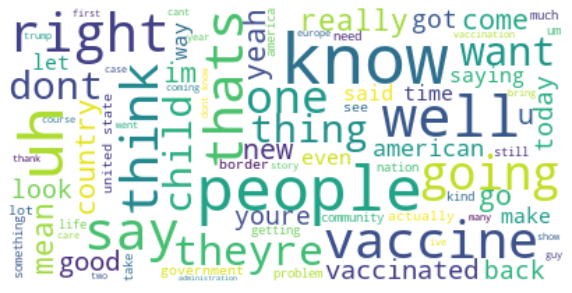

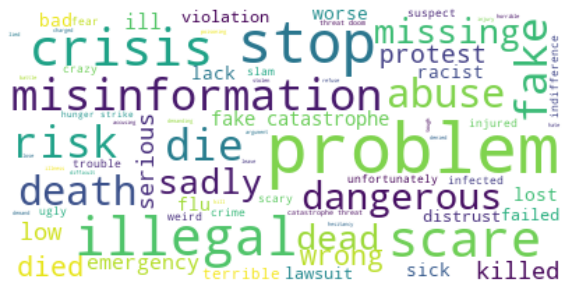

In [16]:
#6. Right Media Bias News Channel Subset Sentiment Analysis

right = data[data['Bias']=='Right'].reset_index()
right = right[['sentiment','text']]
    #right: subset of only the videos that have publishers in the "right" media bias

a_right = []
b_right = []
for i in range(len(right['text'])):
    a_right = " ".join(right['text'][i])
    b_right.append(a_right)

b_right = pd.DataFrame(b_right)
b_right.columns = {'script'}

c_right = ' '.join(b_right['script'])

#WORDCLOUD: 80 Most Commonly Occurred Words within the right Bias Dataset regardless of the sentiment
fig, ax = plt.subplots(1, 1, figsize  = (10,10))
wordcloud_ALL = WordCloud(max_font_size=50, max_words=80, background_color="white").generate(c_right)
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.axis('off')
plt.show(wordcloud_ALL)


c_right = tokenization(c_right)
c_right = pd.DataFrame(c_right)
c_right.columns = {'words'}

scores=[]
for i in range(len(c_right['words'])):
     score = analyser.polarity_scores(c_right['words'][i])
     score=score['compound']
     scores.append(score)  
c_right['score'] = pd.Series(np.array(scores))

    
sentiment=[]
for i in scores:
     if i>=0.05:
         sentiment.append('Positive')
     elif i<=(-0.05):
         sentiment.append('Negative')
     else:
         sentiment.append('Neutral')
         
c_right['sentiment']=pd.Series(np.array(sentiment))


#WORDCLOUD: 80 Most Commonly Occurred Negative Words within the Left Dataset
d_right = c_right[c_right['sentiment']=='Negative'].reset_index() #exchange to positive or neutral
e_right = ' '.join(d_right['words'])

fig, ax = plt.subplots(1, 1, figsize  = (10,10))
wordcloud_ALL = WordCloud(max_font_size=50, max_words=80, background_color="white").generate(e_right)
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.axis('off')
plt.show(wordcloud_ALL)

In [17]:
#7. Left vs. Right Sentiment Analysis

left_final = c_left
right_final = c_right


#DENSITY GRAPH: Shows the Density of the Polarity Scores of the words utilized in the videos by grouping left/right and sentiment positive/negative
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(left_final.loc[left_final['sentiment'] == 'Positive', "score"], shade=True, color="blue", label="Left_Positive", alpha=.7)
sns.kdeplot(left_final.loc[left_final['sentiment'] == 'Negative', "score"], shade=True, color="g", label="Left_Negative", alpha=.7)
sns.kdeplot(right_final.loc[right_final['sentiment'] == 'Positive', "score"], shade=True, color="pink", label="Right_Positive", alpha=.7)
sns.kdeplot(right_final.loc[right_final['sentiment'] == 'Negative', "score"], shade=True, color="orange", label="Right_Negative", alpha=.7)
plt.title('Density Plot of Word Polarity Score by Sentiment', fontsize=22)
plt.legend()
plt.show()

plt.figure(figsize=(16,10), dpi= 80)
plt.xlim(-.001, .001)
sns.kdeplot(left_final.loc[left_final['sentiment'] == 'Neutral', "score"], shade=True, color="red", label="Left_Neutral", alpha=.7)
sns.kdeplot(right_final.loc[right_final['sentiment'] == 'Neutral', "score"], shade=True, color="grey", label="Right_Neutral", alpha=.7)
plt.title('Density Plot of Neutral Word Polarity Score by Sentiment', fontsize=22)
plt.legend()
plt.show()

NameError: name 'c_left' is not defined

In [14]:
#WAFFLE CHART: Visualizes the Proportion of Negative Words to Positive Words within the scripts of left and right

#left
left_final = c_left[c_left['sentiment']!='Neutral'].reset_index()
left_polarity = left_final.groupby('sentiment').size().reset_index(name='counts_sentiment')
n_categories = left_polarity.shape[0]
colors_class = [plt.cm.Set3(i/float(n_categories)) for i in range(n_categories)]


#right
right_final = c_right[c_right['sentiment']!='Neutral'].reset_index()
right_polarity = right_final.groupby('sentiment').size().reset_index(name='counts_sentiment')
n_categories = right_polarity.shape[0]
colors_right = [plt.cm.Set3(i/float(n_categories)) for i in range(n_categories)]

#WAFFLE CHART: !!!!!!Still trying to figure out how to make the two charts proportionate!!!!!
from pywaffle import Waffle
fig = plt.figure(
    FigureClass=Waffle,
    plots={
        '211': {
            'values': left_polarity['counts_sentiment'],
            'labels': ["{1}".format(n[0], n[1]) for n in left_polarity[['sentiment', 'counts_sentiment']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12, 'title':'LEFT'},
            'title': {'label': 'Count of Sentiment in Left Bias', 'loc': 'center', 'fontsize':18},
            'colors': colors_class
        },
        '212': {
            'values': right_polarity['counts_sentiment'],
            'labels': ["{1}".format(n[0], n[1]) for n in right_polarity[['sentiment', 'counts_sentiment']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12, 'title':'RIGHT'},
            'title': {'label': 'Count of Sentiment in Right Bias', 'loc': 'center', 'fontsize':18},
            'colors': colors_right

        }
    },
    rows=20,
    figsize=(20, 15)
    )

NameError: name 'c_left' is not defined

In [10]:
#VIOLIN PLOT: Violin Plot of Left vs. Right in terms of word polarity score distribution
    #the plot is split in the middle to show different distribution of sentiment
complete = left_final.append(right_final)
complete = complete[complete['sentiment']!="Neutral"].reset_index()
complete['sentiment_pos'] = 0
complete.index = np.arange(0, len(complete))

# Means = complete.groupby(['bias','sentiment'])['score'].mean()
    #trying to draw a sactterplot of mean score of the polarity scores
    #in progress

for i in range(len(complete['sentiment'])):
    if complete['sentiment'][i] == "Positive":
        complete['sentiment_pos'][i] = True
    else: complete['sentiment_pos'][i] = False


sns.violinplot(x="bias", y="score", hue="sentiment_pos",
            data=complete, split=True, scale='width', inner='quartile')
plt.show()


#!!!!!!! This code works perfectly fine when on Spyder, but does not work on Notebook. In progress to figure out why, but could not just yet

NameError: name 'left_final' is not defined